# Get and prepare data




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from google.cloud import bigquery

import pyarrow
from geopy.geocoders import Nominatim
from geopy import geocoders  


pd.options.display.width = 200

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN
from sklearn.cluster import DBSCAN
import Functions

ModuleNotFoundError: No module named 'Functions'

In [18]:
def read_data_from_bq():
    client = bigquery.Client(project="sys-99216846604078592294427481")
    req="""
SELECT 
        APP.id,
        CASE WHEN tenantrevenues IS NULL THEN 0 ELSE tenantrevenues END AS tenantrevenues,
        DATE_DIFF(date(CURRENT_DATE()),date(PR.birthday), year) AS age,
        CASE WHEN tenantsavings IS NULL THEN 0 ELSE tenantsavings END AS tenantsavings,
        CASE WHEN certifiedtenantrevenues IS NULL THEN 0 ELSE certifiedtenantrevenues END AS certifiedtenantrevenues,
        CASE WHEN certifiedtenantsavings IS NULL THEN 0 ELSE certifiedtenantsavings END AS certifiedtenantsavings,
        professionalstatusid,
        rejectioncount,
        CASE WHEN rentbudget IS NULL THEN 0 ELSE rentbudget END AS rentbudget,
        rentduration,
        roommatesinvited,
        --APP.locality,
        CASE WHEN responsiblepartyid IS NOT NULL THEN 1 ELSE 0 END AS have_rp,
        CASE WHEN responsiblepartysavings IS NULL THEN 0 ELSE responsiblepartysavings END AS responsiblepartysavings,
        CASE WHEN certifiedresponsiblepartysavings IS NULL THEN 0 ELSE certifiedresponsiblepartysavings END AS certifiedresponsiblepartysavings,
        CASE WHEN responsiblepartyrevenues IS NULL THEN 0 ELSE responsiblepartyrevenues END AS responsiblepartyrevenues,
        CASE WHEN certifiedresponsiblepartyrevenues IS NULL THEN 0 ELSE certifiedresponsiblepartyrevenues END AS certifiedresponsiblepartyrevenues,
        CASE WHEN responsiblepartyprofessionalstatusid IS NULL THEN 6 ELSE responsiblepartyprofessionalstatusid END AS responsiblepartyprofessionalstatusid,
        CASE
        WHEN cotenancytypeid =1 then 1              --(alone)
        WHEN cotenancytypeid = 2 then 2             --(freind cotenants)
        WHEN cotenancytypeid in (3,4,6,7) then 3    --(couple)
        WHEN cotenancytypeid = 5 THEN 4             --(dont know)
        END AS cotenancytype,

        CASE WHEN prescriberpromocodeid IS NOT NULL THEN 1 ELSE 0 END AS have_prescrib_promo,
        CASE WHEN promocodeid IS NOT NULL THEN 1 ELSE 0 END AS have_promo,
        CAST (rtrim(ltrim(REPLACE (CAST (DATE (APP.createdAt) AS STRING), '-', ''))) AS bigint) as createdat
        --DATE (APP.createdAt) as createdat
    FROM `datawarehouse-267911.db_production_console.garantme_Application` APP

    left join  `datawarehouse-267911.db_production_console.garantme_Tenant` TN on TN.id= APP.tenantid 
    LEFT JOIN `datawarehouse-267911.db_production_console.garantme_Profile` PR
    on TN.profileid = PR.id
    WHERE 
            DATE(APP.createdAt) >= DATE(2020,1, 1)
            AND DATE (APP.createdAt) < DATE(2022,4, 27)
            AND APP.firstcertifiedat is not null
            AND producttypeid= 1
            AND APP.deletedAt IS NULL
            AND PR.birthday is not null
            AND APP.professionalstatusid is not null

            --AND DATE (PR.birthday) <= CURRENT_DATE()
            order by PR.birthday desc
    """
    return client.query(req).to_dataframe()

In [19]:
dfB= read_data_from_bq()

In [20]:
dfB

,id,tenantrevenues,age,tenantsavings,certifiedtenantrevenues,certifiedtenantsavings,professionalstatusid,rejectioncount,rentbudget,rentduration,...,have_rp,responsiblepartysavings,certifiedresponsiblepartysavings,responsiblepartyrevenues,certifiedresponsiblepartyrevenues,responsiblepartyprofessionalstatusid,cotenancytype,have_prescrib_promo,have_promo,createdat
0,83224,1300.0,-75,0.0,1300.0,0.0,4,0,300.0,10,...,1,0.0,0.0,0.0,0.0,6,1,0,0,20200408
1,83445,2500.0,3,0.0,2500.0,0.0,4,0,950.0,13,...,1,0.0,0.0,0.0,0.0,6,1,0,0,20200408
2,160429,9930.0,4,30100.0,1895.0,57300.0,5,0,2500.0,12,...,0,0.0,0.0,0.0,0.0,6,3,0,0,20201229
3,258611,4800.0,15,50000.0,2000.0,22600.0,6,0,1000.0,12,...,0,0.0,0.0,0.0,0.0,6,1,0,0,20210810
4,303696,3000.0,16,3000.0,3000.0,3000.0,6,0,1320.0,12,...,0,0.0,0.0,0.0,0.0,6,1,0,0,20211015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85683,367256,1100.0,96,200000.0,796.0,159147.0,7,0,950.0,12,...,0,0.0,0.0,0.0,0.0,6,1,0,0,20220218
85684,178337,1200.0,96,250000.0,1148.0,198900.0,7,0,950.0,12,...,1,0.0,0.0,1200.0,0.0,7,1,0,0,20210315
85685,115415,1680.0,96,0.0,1746.0,0.0,7,0,600.0,12,...,0,0.0,0.0,0.0,0.0,6,2,0,0,20200726
85686,144192,1200.0,98,10500.0,860.0,10000.0,7,0,499.0,12,...,1,0.0,0.0,0.0,3140.0,9,1,0,0,20201013


# Visualising raw data

In [21]:
#Remove qualitative variables

df_num= dfB.drop(['id','have_rp', 'professionalstatusid','responsiblepartyprofessionalstatusid', 'have_prescrib_promo', 'have_promo', 'cotenancytype'], axis = 1)
df_num

,tenantrevenues,age,tenantsavings,certifiedtenantrevenues,certifiedtenantsavings,rejectioncount,rentbudget,rentduration,roommatesinvited,responsiblepartysavings,certifiedresponsiblepartysavings,responsiblepartyrevenues,certifiedresponsiblepartyrevenues,createdat
0,1300.0,-75,0.0,1300.0,0.0,0,300.0,10,0,0.0,0.0,0.0,0.0,20200408
1,2500.0,3,0.0,2500.0,0.0,0,950.0,13,0,0.0,0.0,0.0,0.0,20200408
2,9930.0,4,30100.0,1895.0,57300.0,0,2500.0,12,0,0.0,0.0,0.0,0.0,20201229
3,4800.0,15,50000.0,2000.0,22600.0,0,1000.0,12,0,0.0,0.0,0.0,0.0,20210810
4,3000.0,16,3000.0,3000.0,3000.0,0,1320.0,12,0,0.0,0.0,0.0,0.0,20211015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85683,1100.0,96,200000.0,796.0,159147.0,0,950.0,12,0,0.0,0.0,0.0,0.0,20220218
85684,1200.0,96,250000.0,1148.0,198900.0,0,950.0,12,0,0.0,0.0,1200.0,0.0,20210315
85685,1680.0,96,0.0,1746.0,0.0,0,600.0,12,2,0.0,0.0,0.0,0.0,20200726
85686,1200.0,98,10500.0,860.0,10000.0,0,499.0,12,0,0.0,0.0,0.0,3140.0,20201013


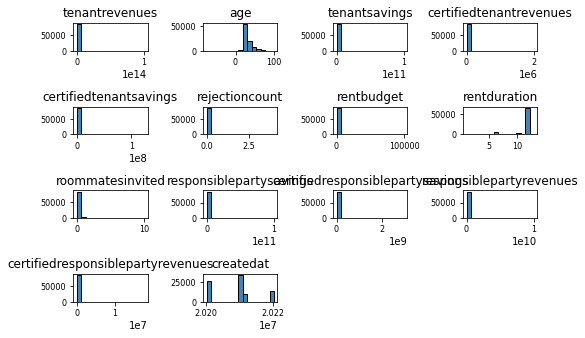

In [22]:
#Histograms

df_num.hist(bins=15, color='steelblue', edgecolor='black', linewidth=1.0,
           xlabelsize=8, ylabelsize=8, grid=False)    
plt.tight_layout(rect=(0, 0, 1.2, 1.2)) 

/Users/User/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


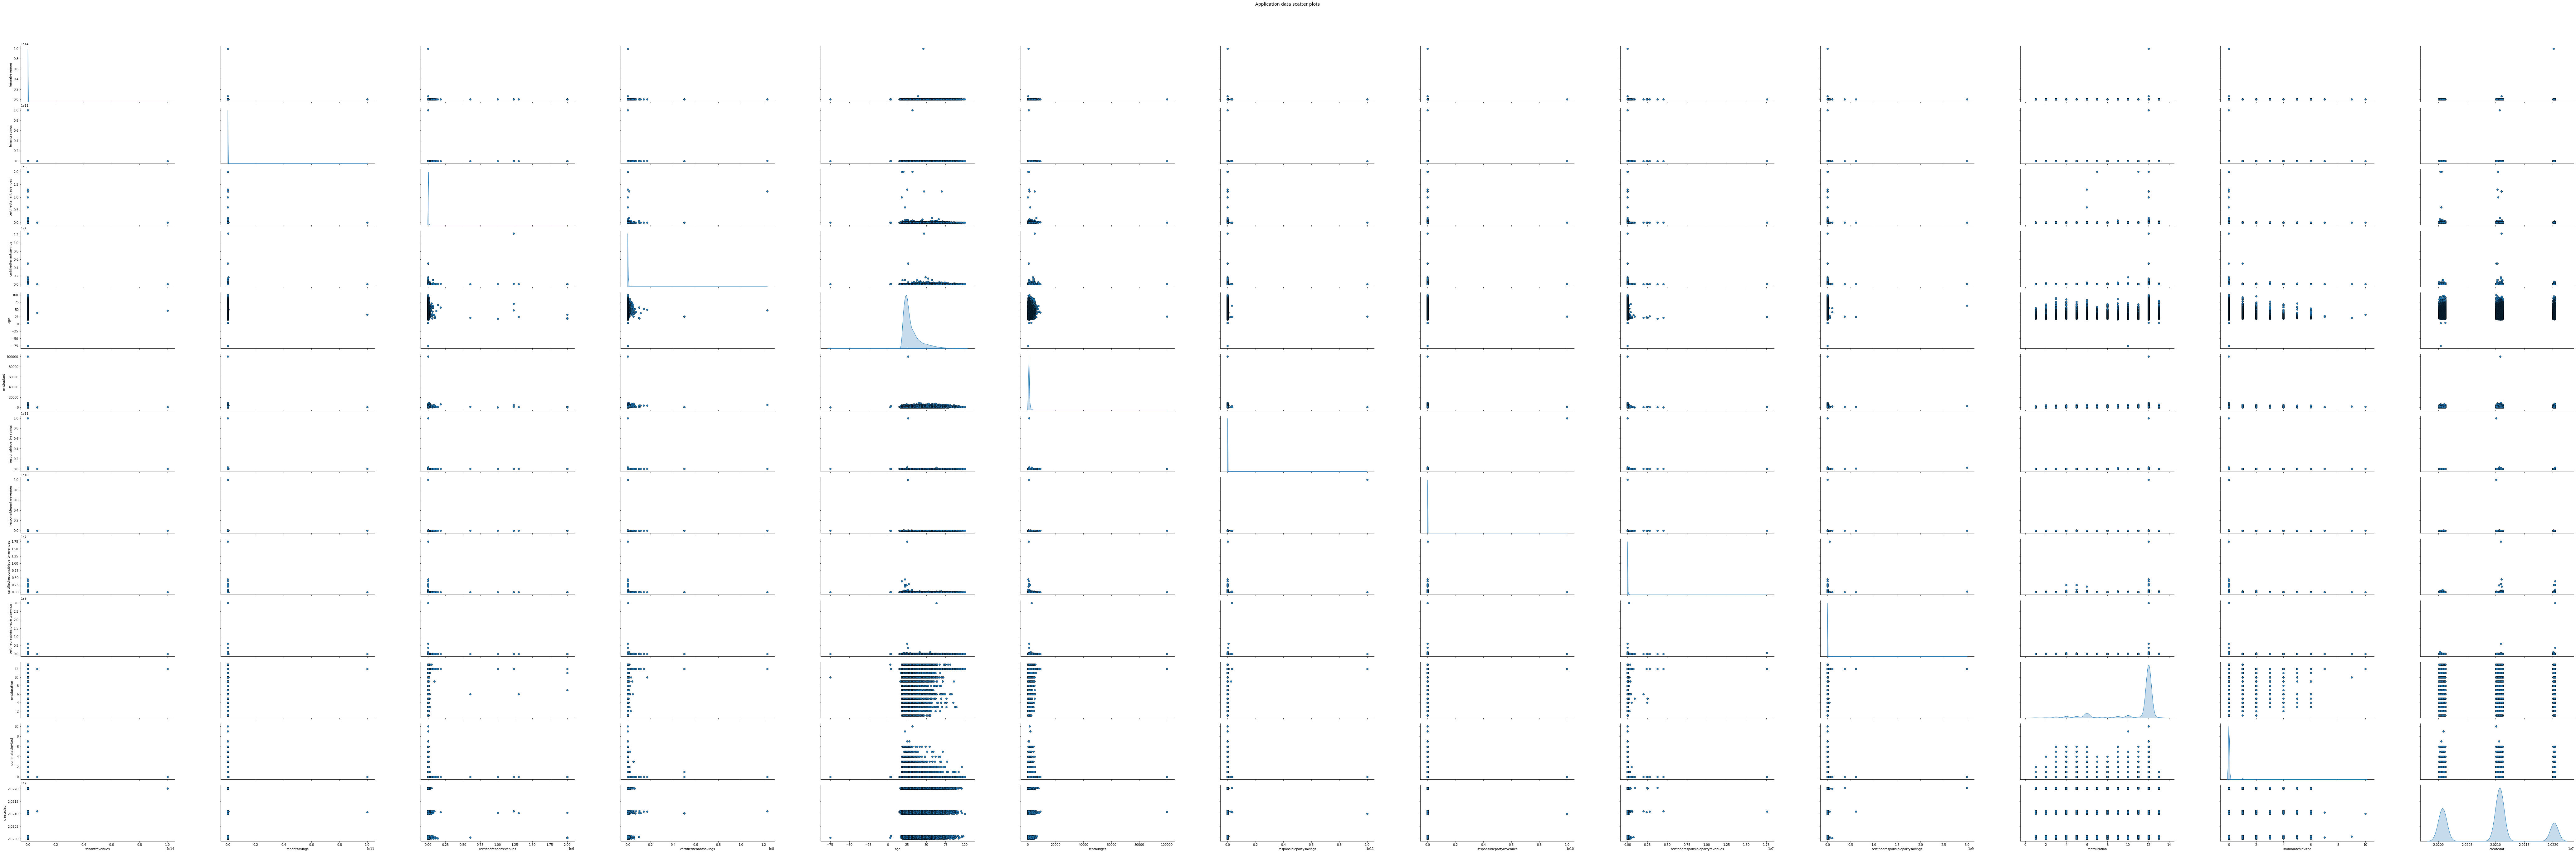

In [23]:


# Pair-wise Scatter Plots
cols = ['tenantrevenues', 'tenantsavings', 'certifiedtenantrevenues', 'certifiedtenantsavings', 'age', 'rentbudget','responsiblepartysavings', 'responsiblepartyrevenues', 'certifiedresponsiblepartyrevenues', 'certifiedresponsiblepartysavings','rentduration', 'roommatesinvited', 'createdat']
pp = sns.pairplot(df_num[cols], size=3, aspect=3,
                  plot_kws=dict(edgecolor="k", linewidth=0.5),
                  diag_kind="kde", diag_kws=dict(shade=True))

fig = pp.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Application data scatter plots', fontsize=14)

Text(0, 0.5, 'Revenue')

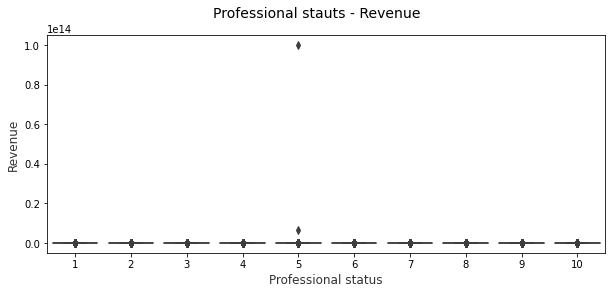

In [27]:
#Boxplots

f, (ax) = plt.subplots(1, 1, figsize=(10, 4))
f.suptitle('Professional stauts - Revenue', fontsize=14)

sns.boxplot(x="professionalstatusid", y="tenantrevenues", data=dfB,  ax=ax)
ax.set_xlabel("Professional status",size = 12,alpha=.8)
ax.set_ylabel("Revenue",size = 12,alpha=.8)

Text(0, 0.5, 'Revenue')

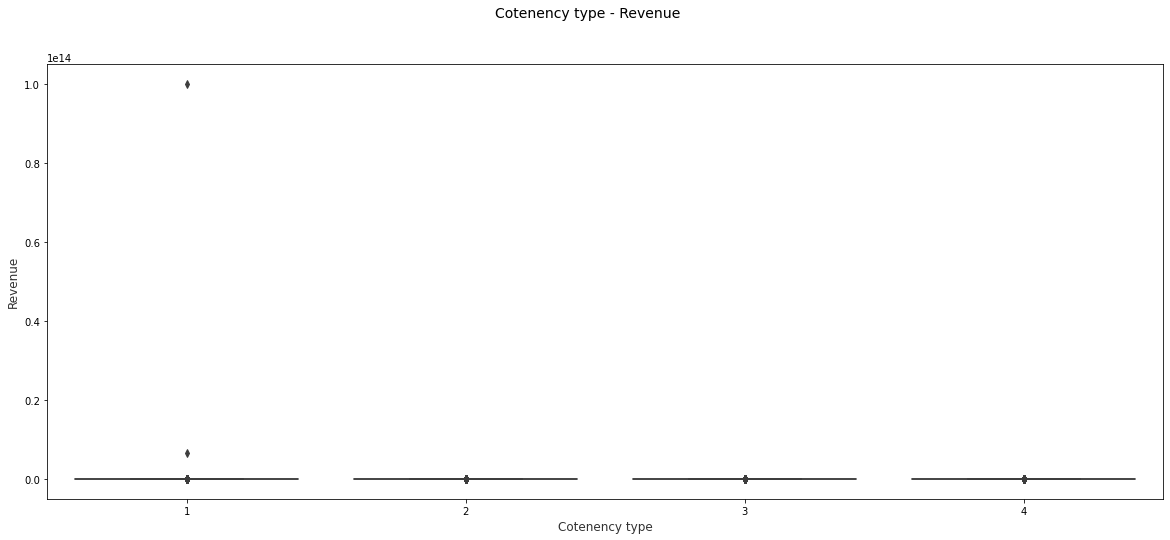

In [52]:
#Boxplots


f, (ax) = plt.subplots(1, 1, figsize=(20, 8))
f.suptitle('Cotenency type - Revenue', fontsize=14)

sns.boxplot(x="cotenancytype", y="tenantrevenues", data=dfB,  ax=ax)
ax.set_xlabel("Cotenency type",size = 12,alpha=.8)
ax.set_ylabel("Revenue",size = 12,alpha=.8)

 # One-hot encoding (not really necessary)

In [54]:
def one_hot_en (df):
    
    onehotdata = {'professionalstatusid': 'TnProSt', 'responsiblepartyprofessionalstatusid': 'RPProSt', 'cotenancytype': 'CoTType'}
    
    for key in onehotdata:
        one_hot = pd.get_dummies(df[key],prefix=onehotdata[key])
        # Drop column B as it is now encoded
        df = df.drop(key ,axis = 1)

        # Join the encoded df
        df = df.join(one_hot)
    return (df)

In [58]:
dfM=dfT=one_hot_en (dfB)

# Create and train model

In [28]:
dfM = dfB

In [37]:
dfM

,id,tenantrevenues,age,tenantsavings,certifiedtenantrevenues,certifiedtenantsavings,professionalstatusid,rejectioncount,rentbudget,rentduration,...,certifiedresponsiblepartysavings,responsiblepartyrevenues,certifiedresponsiblepartyrevenues,responsiblepartyprofessionalstatusid,cotenancytype,have_prescrib_promo,have_promo,createdat,anomaly,scores
0,83224,1300.0,-75,0.0,1300.0,0.0,4,0,300.0,10,...,0.0,0.0,0.0,6,1,0,0,20200408,1,0.121161
1,83445,2500.0,3,0.0,2500.0,0.0,4,0,950.0,13,...,0.0,0.0,0.0,6,1,0,0,20200408,1,0.114025
2,160429,9930.0,4,30100.0,1895.0,57300.0,5,0,2500.0,12,...,0.0,0.0,0.0,6,3,0,0,20201229,1,0.016241
3,258611,4800.0,15,50000.0,2000.0,22600.0,6,0,1000.0,12,...,0.0,0.0,0.0,6,1,0,0,20210810,1,0.110867
4,303696,3000.0,16,3000.0,3000.0,3000.0,6,0,1320.0,12,...,0.0,0.0,0.0,6,1,0,0,20211015,1,0.121461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85683,367256,1100.0,96,200000.0,796.0,159147.0,7,0,950.0,12,...,0.0,0.0,0.0,6,1,0,0,20220218,1,0.006978
85684,178337,1200.0,96,250000.0,1148.0,198900.0,7,0,950.0,12,...,0.0,1200.0,0.0,7,1,0,0,20210315,1,0.005979
85685,115415,1680.0,96,0.0,1746.0,0.0,7,0,600.0,12,...,0.0,0.0,0.0,6,2,0,0,20200726,1,0.013455
85686,144192,1200.0,98,10500.0,860.0,10000.0,7,0,499.0,12,...,0.0,0.0,3140.0,9,1,0,0,20201013,1,0.064512


In [29]:
to_model_columns=dfM.columns[1:21]


In [34]:
clf=IsolationForest(n_estimators=10000, max_samples='auto', contamination='auto', \
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)
clf.fit(dfM[to_model_columns])
pred = clf.predict(dfM[to_model_columns])
dfM['anomaly']=pred
dfM['scores']=clf.decision_function(dfM[to_model_columns])

outliers=dfM.loc[dfM['anomaly']==-1]
outlier_index=list(outliers.index)
#print(outlier_index)
#Find the number of anomalies and normal points here points classified -1 are anomalous
print(dfM['anomaly'].value_counts())

 1    80658
-1     5030
Name: anomaly, dtype: int64


In [38]:
dfM.to_excel(r'/Users/User/Desktop/ANO_RES.xlsx', index = False)


# Visualisations PCA

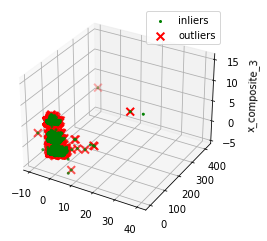

In [39]:
pca = PCA(n_components=3)  # Reduce to k=3 dimensions
scaler = StandardScaler()

#outlier_index=list(outliers.index)
#normalize the metrics
X = scaler.fit_transform(dfM[to_model_columns])
X_reduce = pca.fit_transform(X)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")
# Plot the compressed data points
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=1, label="inliers",c="green")
# Plot x's for the ground truth outliers
ax.scatter(X_reduce[outlier_index,0],X_reduce[outlier_index,1], X_reduce[outlier_index,2],
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()
plt.show()

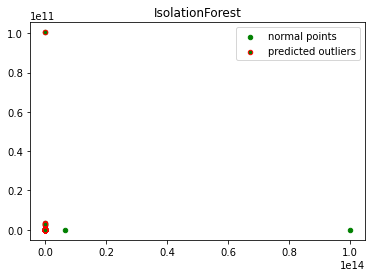

In [40]:
pca = PCA(2)
pca.fit(dfM[to_model_columns])
res=pd.DataFrame(pca.transform(dfM[to_model_columns]))
Z = np.array(res)
plt.title("IsolationForest")
plt.contourf( Z, cmap=plt.cm.Blues_r)
b1 = plt.scatter(res[0], res[1], c='green',
                 s=20,label="normal points")
b1 =plt.scatter(res.iloc[outlier_index,0],res.iloc[outlier_index,1], c='green',s=20,  edgecolor="red",label="predicted outliers")
plt.legend(loc="upper right")
plt.show()

# Treating new data

In [42]:
def read_data_from_bqN():
    client = bigquery.Client(project="sys-99216846604078592294427481")
    req="""
SELECT 
        APP.id,
        CASE WHEN tenantrevenues IS NULL THEN 0 ELSE tenantrevenues END AS tenantrevenues,
        DATE_DIFF(date(CURRENT_DATE()),date(PR.birthday), year) AS age,
        CASE WHEN tenantsavings IS NULL THEN 0 ELSE tenantsavings END AS tenantsavings,
        CASE WHEN certifiedtenantrevenues IS NULL THEN 0 ELSE certifiedtenantrevenues END AS certifiedtenantrevenues,
        CASE WHEN certifiedtenantsavings IS NULL THEN 0 ELSE certifiedtenantsavings END AS certifiedtenantsavings,
        professionalstatusid,
        rejectioncount,
        CASE WHEN rentbudget IS NULL THEN 0 ELSE rentbudget END AS rentbudget,
        rentduration,
        roommatesinvited,
        --APP.locality,
        CASE WHEN responsiblepartyid IS NOT NULL THEN 1 ELSE 0 END AS have_rp,
        CASE WHEN responsiblepartysavings IS NULL THEN 0 ELSE responsiblepartysavings END AS responsiblepartysavings,
        CASE WHEN certifiedresponsiblepartysavings IS NULL THEN 0 ELSE certifiedresponsiblepartysavings END AS certifiedresponsiblepartysavings,
        CASE WHEN responsiblepartyrevenues IS NULL THEN 0 ELSE responsiblepartyrevenues END AS responsiblepartyrevenues,
        CASE WHEN certifiedresponsiblepartyrevenues IS NULL THEN 0 ELSE certifiedresponsiblepartyrevenues END AS certifiedresponsiblepartyrevenues,
        CASE WHEN responsiblepartyprofessionalstatusid IS NULL THEN 6 ELSE responsiblepartyprofessionalstatusid END AS responsiblepartyprofessionalstatusid,
        CASE
        WHEN cotenancytypeid =1 then 1              --(alone)
        WHEN cotenancytypeid = 2 then 2             --(freind cotenants)
        WHEN cotenancytypeid in (3,4,6,7) then 3    --(couple)
        WHEN cotenancytypeid = 5 THEN 4             --(dont know)
        END AS cotenancytype,

        CASE WHEN prescriberpromocodeid IS NOT NULL THEN 1 ELSE 0 END AS have_prescrib_promo,
        CASE WHEN promocodeid IS NOT NULL THEN 1 ELSE 0 END AS have_promo,
        CAST (rtrim(ltrim(REPLACE (CAST (DATE (APP.createdAt) AS STRING), '-', ''))) AS bigint) as createdat
        --DATE (APP.createdAt) as createdat
    FROM `datawarehouse-267911.db_production_console.garantme_Application` APP

    left join  `datawarehouse-267911.db_production_console.garantme_Tenant` TN on TN.id= APP.tenantid 
    LEFT JOIN `datawarehouse-267911.db_production_console.garantme_Profile` PR
    on TN.profileid = PR.id
    WHERE 
            DATE(APP.createdAt) >= DATE(2022,4, 27)
            --AND DATE (APP.createdAt) <= DATE(2021,12, 31)
            --AND APP.firstcertifiedat is not null
            AND producttypeid= 1
            AND APP.deletedAt IS NULL
            AND PR.birthday is not null
            AND APP.professionalstatusid is not null
            --AND DATE (PR.birthday) <= CURRENT_DATE()
            order by PR.birthday desc
    """
    return client.query(req).to_dataframe()

In [43]:
dfN= read_data_from_bqN()

In [44]:
dfN

,id,tenantrevenues,age,tenantsavings,certifiedtenantrevenues,certifiedtenantsavings,professionalstatusid,rejectioncount,rentbudget,rentduration,...,have_rp,responsiblepartysavings,certifiedresponsiblepartysavings,responsiblepartyrevenues,certifiedresponsiblepartyrevenues,responsiblepartyprofessionalstatusid,cotenancytype,have_prescrib_promo,have_promo,createdat
0,409836,0.0,17,0.0,0.0,0.0,6,0,730.0,12,...,1,0.0,0.0,0.0,0.0,6,3,0,0,20220427
1,409791,0.0,17,0.0,0.0,0.0,1,0,250.0,12,...,0,0.0,0.0,0.0,0.0,6,1,0,0,20220427
2,409840,900.0,18,5000.0,900.0,5000.0,2,0,350.0,12,...,0,0.0,0.0,0.0,0.0,6,3,0,0,20220427
3,409760,419.0,18,150.0,419.0,150.0,8,0,419.0,12,...,1,80.0,80.0,80.0,80.0,8,3,0,0,20220427
4,409797,0.0,19,0.0,0.0,0.0,1,0,580.0,9,...,1,600.0,600.0,900.0,900.0,6,1,0,0,20220427
5,409763,1500.0,19,500.0,1500.0,500.0,6,0,500.0,12,...,0,0.0,0.0,0.0,0.0,6,1,0,0,20220427
6,409786,0.0,19,0.0,0.0,0.0,1,0,250.0,3,...,1,2000.0,2000.0,450.0,450.0,1,1,0,0,20220427
7,409812,1250.0,20,1000.0,1250.0,1000.0,8,0,405.0,12,...,0,0.0,0.0,0.0,0.0,6,1,0,0,20220427
8,409767,0.0,20,1000.0,0.0,1000.0,6,0,67.0,6,...,0,0.0,0.0,0.0,0.0,6,4,0,0,20220427
9,409780,0.0,20,0.0,0.0,0.0,1,0,900.0,12,...,1,0.0,0.0,0.0,0.0,7,3,0,0,20220427


In [45]:
to_model_columns=dfN.columns[1:21]
pred = clf.predict(dfN[to_model_columns])
dfN['anomaly']=pred
dfN['scores']=clf.decision_function(dfN[to_model_columns])
outliers=dfN.loc[dfN['anomaly']==-1]
outlier_index=list(outliers.index)
print(dfN['anomaly'].value_counts())

1    59
Name: anomaly, dtype: int64


In [46]:
dfN

,id,tenantrevenues,age,tenantsavings,certifiedtenantrevenues,certifiedtenantsavings,professionalstatusid,rejectioncount,rentbudget,rentduration,...,certifiedresponsiblepartysavings,responsiblepartyrevenues,certifiedresponsiblepartyrevenues,responsiblepartyprofessionalstatusid,cotenancytype,have_prescrib_promo,have_promo,createdat,anomaly,scores
0,409836,0.0,17,0.0,0.0,0.0,6,0,730.0,12,...,0.0,0.0,0.0,6,3,0,0,20220427,1,0.092120
1,409791,0.0,17,0.0,0.0,0.0,1,0,250.0,12,...,0.0,0.0,0.0,6,1,0,0,20220427,1,0.114107
2,409840,900.0,18,5000.0,900.0,5000.0,2,0,350.0,12,...,0.0,0.0,0.0,6,3,0,0,20220427,1,0.077976
3,409760,419.0,18,150.0,419.0,150.0,8,0,419.0,12,...,80.0,80.0,80.0,8,3,0,0,20220427,1,0.078233
4,409797,0.0,19,0.0,0.0,0.0,1,0,580.0,9,...,600.0,900.0,900.0,6,1,0,0,20220427,1,0.126218
5,409763,1500.0,19,500.0,1500.0,500.0,6,0,500.0,12,...,0.0,0.0,0.0,6,1,0,0,20220427,1,0.119966
6,409786,0.0,19,0.0,0.0,0.0,1,0,250.0,3,...,2000.0,450.0,450.0,1,1,0,0,20220427,1,0.046608
7,409812,1250.0,20,1000.0,1250.0,1000.0,8,0,405.0,12,...,0.0,0.0,0.0,6,1,0,0,20220427,1,0.115654
8,409767,0.0,20,1000.0,0.0,1000.0,6,0,67.0,6,...,0.0,0.0,0.0,6,4,0,0,20220427,1,0.018390
9,409780,0.0,20,0.0,0.0,0.0,1,0,900.0,12,...,0.0,0.0,0.0,7,3,0,0,20220427,1,0.101546


# Visualisations PCA

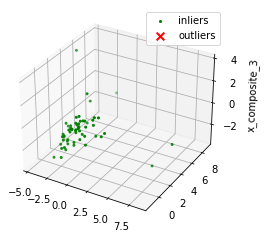

In [47]:
pca = PCA(n_components=3)  # Reduce to k=3 dimensions
scaler = StandardScaler()

#outlier_index=list(outliers.index)
#normalize the metrics
X = scaler.fit_transform(dfN[to_model_columns])
X_reduce = pca.fit_transform(X)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")
# Plot the compressed data points
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=1, label="inliers",c="green")
# Plot x's for the ground truth outliers
ax.scatter(X_reduce[outlier_index,0],X_reduce[outlier_index,1], X_reduce[outlier_index,2],
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()
plt.show()

In [129]:
dfN

,id,tenantrevenues,age,tenantsavings,certifiedtenantrevenues,certifiedtenantsavings,professionalstatusid,rejectioncount,rentbudget,rentduration,...,certifiedresponsiblepartysavings,responsiblepartyrevenues,certifiedresponsiblepartyrevenues,responsiblepartyprofessionalstatusid,cotenancytype,have_prescrib_promo,have_promo,createdat,anomaly,scores
0,409049,0.0,17,0.0,0.0,0.0,1,0,500.0,12,...,0.0,0.0,0.0,6,1,0,0,20220426,1,0.130572
1,409417,0.0,17,0.0,0.0,0.0,1,0,350.0,12,...,0.0,0.0,0.0,6,2,0,0,20220426,1,0.121121
2,409000,689.0,18,0.0,689.0,0.0,2,0,276.0,12,...,0.0,0.0,0.0,6,1,0,0,20220426,1,0.131609
3,408920,0.0,18,0.0,0.0,0.0,1,0,1000.0,12,...,4000.0,4000.0,4000.0,9,1,0,0,20220426,1,0.103498
4,408974,0.0,18,0.0,0.0,0.0,1,0,550.0,12,...,3500.0,1800.0,1800.0,9,1,0,0,20220426,1,0.120393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328,409235,1540.0,74,0.0,1540.0,0.0,7,0,700.0,12,...,0.0,0.0,0.0,6,3,0,0,20220426,1,0.071170
329,409105,1840.0,74,500000.0,1840.0,500000.0,7,0,1850.0,12,...,0.0,0.0,0.0,6,1,0,0,20220426,-1,-0.091195
330,409373,984.0,75,0.0,984.0,0.0,7,0,394.0,12,...,0.0,0.0,0.0,6,1,0,0,20220426,1,0.093183
331,409167,2600.0,76,0.0,2600.0,0.0,7,0,600.0,12,...,0.0,0.0,0.0,6,1,0,0,20220426,1,0.077295


In [130]:
dfN.to_excel(r'/Users/User/Desktop/ANO_RES_N.xlsx', index = False)


# Working wiht numeric values alone

In [391]:
df_num1= dfB.drop(['id','have_rp', 'professionalstatusid','responsiblepartyprofessionalstatusid', 'have_prescrib_promo', 'have_promo', 'cotenancytype'], axis = 1)


In [392]:
df_num1

,tenantrevenues,age,tenantsavings,certifiedtenantrevenues,certifiedtenantsavings,rejectioncount,rentbudget,rentduration,roommatesinvited,responsiblepartysavings,certifiedresponsiblepartysavings,responsiblepartyrevenues,certifiedresponsiblepartyrevenues,createdat
0,1300.0,-75,0.0,1300.0,0.0,0,300.0,10,0,0.0,0.0,0.0,0.0,20200408
1,2500.0,3,0.0,2500.0,0.0,0,950.0,13,0,0.0,0.0,0.0,0.0,20200408
2,9930.0,4,30100.0,1895.0,57300.0,0,2500.0,12,0,0.0,0.0,0.0,0.0,20201229
3,4800.0,15,50000.0,2000.0,22600.0,0,1000.0,12,0,0.0,0.0,0.0,0.0,20210810
4,3000.0,16,3000.0,3000.0,3000.0,0,1320.0,12,0,0.0,0.0,0.0,0.0,20211015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85458,1100.0,96,200000.0,796.0,159147.0,0,950.0,12,0,0.0,0.0,0.0,0.0,20220218
85459,1200.0,96,250000.0,1148.0,198900.0,0,950.0,12,0,0.0,0.0,1200.0,0.0,20210315
85460,1680.0,96,0.0,1746.0,0.0,0,600.0,12,2,0.0,0.0,0.0,0.0,20200726
85461,1200.0,98,10500.0,860.0,10000.0,0,499.0,12,0,0.0,0.0,0.0,3140.0,20201013


In [397]:
outlier_detection = DBSCAN(min_samples = 2, eps = 3)
clusters = outlier_detection.fit_predict(df_num1 [1:14])
pred = DBSCAN.predict(df_num[to_model_columns])

df_num1['anomaly']=pred

outliers=df_num1.loc[df_num1['anomaly']==-1]

list(clusters).count(-1)

AttributeError: type object 'DBSCAN' has no attribute 'predict'

In [394]:
clusters

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

In [716]:

to_model_columns=df_num1.columns[1:17]
clf=IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.001), \
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)
clf.fit(df_num1[to_model_columns])
pred = clf.predict(df_num1[to_model_columns])
df_num1['anomaly']=pred
outliers=df.loc[df_num1['anomaly']==-1]
outlier_index=list(outliers.index)
#print(outlier_index)
#Find the number of anomalies and normal points here points classified -1 are anomalous
print(df_num1['anomaly'].value_counts())

 1    6531
-1       7
Name: anomaly, dtype: int64


## Univariate

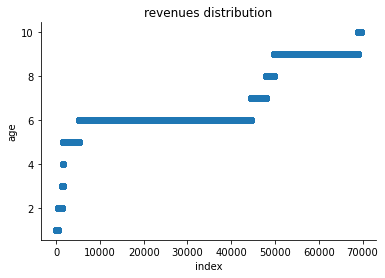

In [38]:
plt.scatter(range(df.shape[0]), np.sort(df['responsiblepartyprofessionalstatusid'].values))
plt.xlabel('index')
plt.ylabel('age')
plt.title("revenues distribution")
sns.despine()

{'whiskers': [<matplotlib.lines.Line2D at 0x7ffbd73bd9d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7ffbd73bd220>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ffbd73bd6a0>],
 'medians': [<matplotlib.lines.Line2D at 0x7ffbd0021f10>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ffbd0021d00>],
 'means': []}

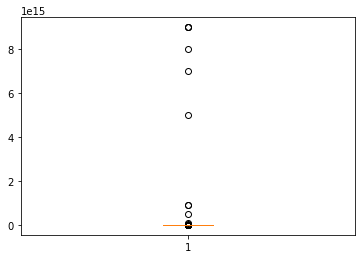

In [41]:
plt.boxplot(df['tenantrevenues'].values)


## Isolation

In [82]:

clf=IsolationForest(n_estimators=100, max_samples='auto', contamination=float(0.03))
clf.fit(df[to_model_columns])

df['scores']=clf.decision_function(df[to_model_columns])
df['anomaly']=clf.predict(df[to_model_columns])
print(df[[*to_model_columns, "scores", "anomaly"]].head(20))

    tenantrevenues  age  tenantsavings  certifiedtenantrevenues  certifiedtenantsavings  rejectioncount  rentbudget  rentduration  roommatesinvited  have_rp  ...  RPProSt_7  RPProSt_8  RPProSt_9  \
0           3575.0   31           0.00                  3575.00                     0.0               0       990.0            12                 0        0  ...          0          0          0   
1           2535.0   28           0.00                  2413.00                     0.0               0       650.0            12                 0        0  ...          0          0          0   
2           2340.0   28           0.00                  2340.00                     0.0               0       715.0            12                 0        0  ...          0          0          0   
3            850.0   21           0.00                     0.00                     0.0               0       495.0            12                 0        0  ...          0          0          0   
4         

In [616]:
anomaly=df.loc[df['anomaly']==-1]
anomaly_index=list(anomaly.index)
print(anomaly[[*to_model_columns,"id", "scores", "anomaly"]].sort_values(by=['scores'], ascending=False))

      tenantrevenues  age  tenantsavings  rejectioncount  rentbudget  rentduration  roommatesinvited  have_rp  responsiblepartysavings  responsiblepartyrevenues  have_prescrib_promo  have_promo  \
4038             0.0   22            0.0               0      1000.0             4                 0        1                   2000.0                    2500.0                    0           0   
1515          1100.0   24         1000.0               0       900.0             6                 0        1                  20000.0                    4000.0                    0           0   
6328          2500.0   32        20000.0               0      1100.0            12                 0        1                  25000.0                    3000.0                    1           1   
1964          1250.0   34            0.0               0       600.0            12                 3        1                      0.0                     980.0                    0           0   
6009          2

In [618]:

xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
clf = IsolationForest(contamination=outliers_fraction,random_state=0)
clf.fit(X)
scores_pred = clf.decision_function(X) * -1

y_pred = clf.predict(X)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)
plt.figure(figsize=(8, 8))

df1 = df
df1['outlier'] = y_pred.tolist()
    
# sales - inlier feature 1,  profit - inlier feature 2
inliers_sales = np.array(df['tenantsavings'][df['anomaly'] == 0]).reshape(-1,1)
inliers_profit = np.array(df['tenantrevenues'][df['anomaly'] == 0]).reshape(-1,1)
    
# sales - outlier feature 1, profit - outlier feature 2
inliers_sales = np.array(df['tenantsavings'][df['anomaly'] == 1]).reshape(-1,1)
inliers_profit = np.array(df['tenantrevenues'][df['anomaly'] == 1]).reshape(-1,1)
         
print('OUTLIERS: ',n_outliers,'INLIERS: ',n_inliers)

threshold = percentile(scores_pred, 100 * outliers_fraction)
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
b = plt.scatter(inliers_sales, inliers_profit, c='white',s=20, edgecolor='k')
    
c = plt.scatter(outliers_sales, outliers_profit, c='black',s=20, edgecolor='k')
       
plt.axis('tight')
plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers','outliers'],
           prop=matplotlib.font_manager.FontProperties(size=20),loc='lower right')      
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('Isolation Forest')
plt.show();

NameError: name 'outliers_fraction' is not defined

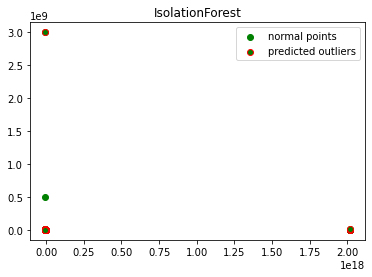

In [620]:
from sklearn.decomposition import PCA

pca = PCA(2)
pca.fit(df[to_model_columns])
res=pd.DataFrame(pca.transform(df[to_model_columns]))

Z = np.array(res)
plt.title("IsolationForest")
plt.contourf( Z, cmap=plt.cm.Blues_r)
b1 = plt.scatter(res[0], res[1], c='green',label="normal points")
b2 = plt.scatter(res.iloc[anomaly_index,0],res.iloc[anomaly_index,1], c='green',  edgecolor="red",label="predicted outliers")
plt.legend(loc="upper right")

plt.show()



In [ ]:
df[column]

In [ ]:
saving = 0


clf.predict()